In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import Image

from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import precision_score, recall_score
import statsmodels.api as sm


#Code to always set working directory one level up so we can access /data easily
import os
if "NOTEBOOK_DIR" not in globals():
    NOTEBOOK_DIR = os.getcwd()
    print('Notebook Directory Set:', os.getcwd())

os.chdir(os.path.join(NOTEBOOK_DIR, ".."))
print("Current working directory:", os.getcwd())

Notebook Directory Set: /shared_folder/eas_508_project/notebooks
Current working directory: /shared_folder/eas_508_project


In [2]:
#Create Remove Plays func for clean_data func
def remove_plays(dataframe):
    df = dataframe.copy()

    formation = df['offense_formation'].notna()
    personnel = df['offense_personnel'].notna()
    no_play = df['play_type'] != 'no_play'
    kneel = df['qb_kneel'] == 0
    spike = df['qb_spike'] == 0

    df = df[formation & personnel & no_play & kneel & spike].drop(columns=['qb_kneel','qb_spike'])

    df = df[df['down'].notna()]

    return df

In [3]:
pbp_path = 'data/raw/pbp_data/'

pbp_name = 'pbp_2016.csv'

fb_df = pd.read_csv(pbp_path + pbp_name)
shape = fb_df.shape
columns = fb_df.columns

print('✔✔✔ File Loaded\n')
print(f'Shape: {shape}\n')
print(f'Column Names: {list(columns)}\n')

fb_df.head()

/tmp/ipykernel_17281/3081738536.py:5: DtypeWarning: Columns (196,197,199,200,206,207,210,211,214,215,220,221,222,223,226,227,235,236,237,265,266,270,271,272,277,279,280,300,301) have mixed types. Specify dtype option on import or set low_memory=False.
  fb_df = pd.read_csv(pbp_path + pbp_name)


✔✔✔ File Loaded

Shape: (47651, 389)

Column Names: ['nflverse_game_id', 'play_id', 'possession_team', 'offense_formation', 'offense_personnel', 'defenders_in_box', 'defense_personnel', 'number_of_pass_rushers', 'players_on_play', 'offense_players', 'defense_players', 'n_offense', 'n_defense', 'ngs_air_yards', 'time_to_throw', 'was_pressure', 'route', 'defense_man_zone_type', 'defense_coverage_type', 'old_game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_poin

,nflverse_game_id,play_id,possession_team,offense_formation,offense_personnel,defenders_in_box,defense_personnel,number_of_pass_rushers,players_on_play,offense_players,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
0,2016_01_BUF_BAL,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016_01_BUF_BAL,36,BUF,NaN,NaN,NaN,NaN,NaN,40078;40151;37977;36060;40494;40053;40253;4011...,00-0030041;00-0030073;00-0029799;00-0030433;00...,...,0,1,-0.955114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016_01_BUF_BAL,58,BAL,I_FORM,"2 RB, 1 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",NaN,38540;41302;40078;35553;38582;43295;40053;4336...,00-0029892;00-0027714;00-0032965;00-0029893;00...,...,1,1,0.336466,NaN,NaN,NaN,NaN,NaN,0.460759,-46.075901
3,2016_01_BUF_BAL,85,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",3.0,41302;40078;38540;35553;43295;38582;40053;4336...,00-0029892;00-0027714;00-0032965;00-0029893;00...,...,0,1,0.644540,1.567466,9.753489,8.0,0.63767,0.530295,0.426425,57.357508
4,2016_01_BUF_BAL,109,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",NaN,40078;38540;41302;35553;43295;38582;40053;4336...,00-0029892;00-0027714;00-0032965;00-0029893;00...,...,0,1,-0.546209,NaN,NaN,NaN,NaN,NaN,0.456597,-45.659652


In [4]:
df = remove_plays(fb_df)

In [5]:
#Convert Offense Personnel to Dictionary Storage for easy recall
def fix_personnel(dataframe):
    df = dataframe.copy()

    df['personnel_dict'] = df['offense_personnel'].apply(lambda x: {pos: int(count) for count, pos in (p.strip().split(' ') for p in x.split(','))})

    df['QB'] = 1
    df['OL'] = 5

    personnel_titles = ['RB','TE','WR','OTHER']

    for pos in personnel_titles:
        df[f'{pos}'] = 0

    def update_personnel_counts(row):
        for k,v in row['personnel_dict'].items():
            if k in personnel_titles:
                row[k] += v
            else:
                if k == 'QB':
                    row[k] = v
                elif k == 'OL':
                    row[k] = v
                else:
                    row['OTHER'] += v
        return row

    df = df.apply(update_personnel_counts, axis=1)

    df = df.drop(columns = ['personnel_dict','offense_personnel'])

    df['extra_lineman_flag'] = np.where(df['OL'] > 5, 1, 0)

    df['bigs'] = df['OL']+df['TE']-5
    df['personnel_num'] = df.apply(lambda x: f'{x['bigs']}{x['RB']}', axis=1)

    return df

In [6]:
df = fix_personnel(df)

/tmp/ipykernel_17281/1925525035.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['extra_lineman_flag'] = np.where(df['OL'] > 5, 1, 0)
/tmp/ipykernel_17281/1925525035.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['bigs'] = df['OL']+df['TE']-5
/tmp/ipykernel_17281/1925525035.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmen

In [ ]:
def win_trim(dataframe, win_perc=0):
    df = dataframe.copy()

    return df[(win_perc < df['wp']) & (df['wp'] < (1-win_perc))]

In [11]:
def model_prep(dataframe, win_perc, features, to_predict=['success']):
    df = dataframe.copy()
    cols_to_keep = features+to_predict

    df = win_trim(df)

    return df[cols_to_keep]

In [ ]:
possible_features = ['down','ydstogo','yardline_100','offense_formation','personnel_num','extra_lineman_flag','play_type','score_differential','success','epa','wp']

In [25]:
list(df.columns)

['nflverse_game_id',
 'play_id',
 'possession_team',
 'offense_formation',
 'defenders_in_box',
 'defense_personnel',
 'number_of_pass_rushers',
 'players_on_play',
 'offense_players',
 'defense_players',
 'n_offense',
 'n_defense',
 'ngs_air_yards',
 'time_to_throw',
 'was_pressure',
 'route',
 'defense_man_zone_type',
 'defense_coverage_type',
 'old_game_id',
 'home_team',
 'away_team',
 'season_type',
 'week',
 'posteam',
 'posteam_type',
 'defteam',
 'side_of_field',
 'yardline_100',
 'game_date',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'game_half',
 'quarter_end',
 'drive',
 'sp',
 'qtr',
 'down',
 'goal_to_go',
 'time',
 'yrdln',
 'ydstogo',
 'ydsnet',
 'desc',
 'play_type',
 'yards_gained',
 'shotgun',
 'no_huddle',
 'qb_dropback',
 'qb_scramble',
 'pass_length',
 'pass_location',
 'air_yards',
 'yards_after_catch',
 'run_location',
 'run_gap',
 'field_goal_result',
 'kick_distance',
 'extra_point_result',
 'two_point_conv_result',
 '

In [ ]:
#Fixed drive can be used to help predict rush or pass based on previous success or pass

,nflverse_game_id,fixed_drive
2,2016_01_BUF_BAL,1
3,2016_01_BUF_BAL,1
4,2016_01_BUF_BAL,1
5,2016_01_BUF_BAL,1
6,2016_01_BUF_BAL,1
...,...,...
47644,2016_21_NE_ATL,24
47645,2016_21_NE_ATL,24
47646,2016_21_NE_ATL,24
47648,2016_21_NE_ATL,24


In [47]:
df['previous_success'] = df.groupby(['nflverse_game_id','fixed_drive'])['success'].shift(1)

/tmp/ipykernel_17281/3173373955.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['previous_success'] = df.groupby(['nflverse_game_id','fixed_drive'])['success'].shift(1)


<Axes: xlabel='previous_success', ylabel='count'>

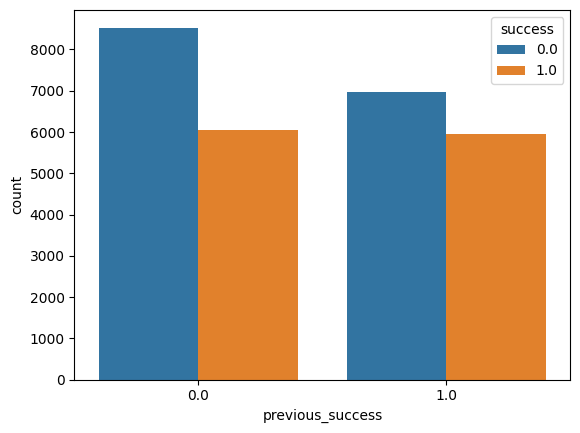

In [61]:
sns.countplot(data=df, x='previous_success', hue='success')